In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
# Open quatratically detrended ts data for the 20 CMIP6 models 
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc')

In [4]:
# Select out tropical Pacific region and apply land mask as only inyterested in SST pattern for now 
sst_region = data.sel(lat=slice(-15,15)).sel(lon=slice(140,280))
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')
# Apply to tropical Pacific region 
sst_region = sst_region.where(landmask.data==0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into ful

In [5]:
# Calculate anomalies 
clims = sst_region.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = sst_region.groupby('time.month') - clims

In [6]:
# Take DJF average
quarterly_anoms = anoms.resample(time='QS-DEC').mean('time')
djf_anoms = quarterly_anoms.isel(time=slice(0,None,4))

In [14]:
# NINO indices 
# Nino3 Index
nino3_list = []
for m in data.model:
    nino3 = func.nino3_index(data.sel(model=m), '1979-01', '2008-12')
    nino3_list.append(nino3/nino3.std())
nino3 = xr.concat(nino3_list, dim='model').chunk('auto')
# Nino4 Index 
nino4_list = []
for m in data.model:
    nino4 = func.nino4_index(data.sel(model=m), '1979-01', '2008-12')
    nino4_list.append(nino4/nino4.std())
nino4 = xr.concat(nino4_list, dim='model').chunk('auto')

In [19]:
# Calculate EP index and CP index
EP = nino3 - 0.5*nino4
CP = nino4 - 0.5*nino3

In [26]:
# Save as netCDF
# EP.to_netcdf('/g/data/w40/rl5183/EP_nino_cmip6_20.nc')
# CP.to_netcdf('/g/data/w40/rl5183/CP_nino_cmip6_20.nc')

In [7]:
EP = xr.open_dataarray('/g/data/w40/rl5183/EP_nino_cmip6_20.nc')
CP = xr.open_dataarray('/g/data/w40/rl5183/CP_nino_cmip6_20.nc')

In [8]:
# Take DJF average of EP index and CP index
quarterly_EP = EP.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))

In [9]:
# Linear regression of SST anomalies onto EP index and CP index
EP_regress_list = []
CP_regress_list = []
for m in djf_anoms.model:
    EP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_EP.sel(model=m).drop_sel(time='1899-12')))
    CP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_CP.sel(model=m).drop_sel(time='1899-12')))

In [10]:
EP_regressions = xr.concat(EP_regress_list, dim='model')
CP_regressions = xr.concat(CP_regress_list, dim='model')

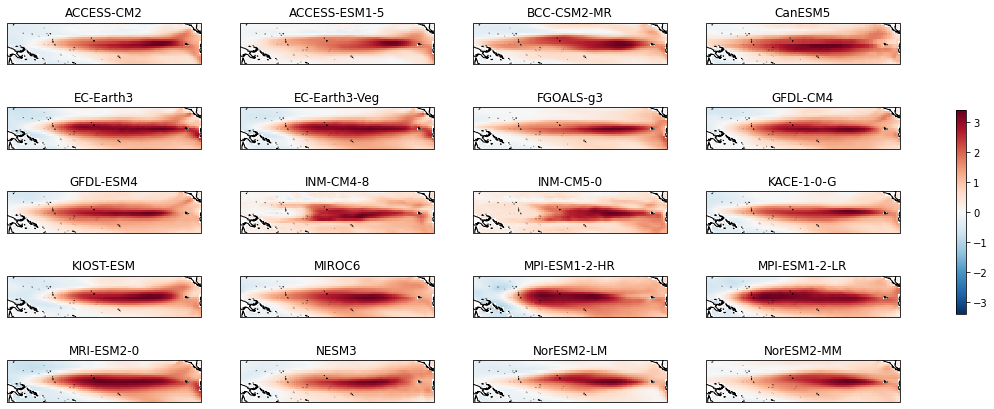

In [119]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(EP_regressions.model):
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    d = EP_regressions.sel(model=m)
    C = d.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_EP_SST_pattern_NINO', bbox_inches='tight', dpi=300)

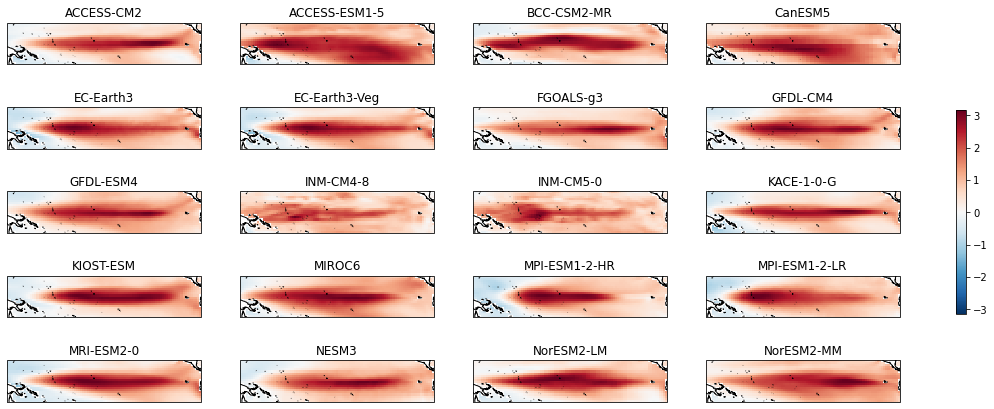

In [120]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(CP_regressions.model):
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    d = CP_regressions.sel(model=m)
    C = d.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_CP_SST_pattern_NINO', bbox_inches='tight', dpi=300)

In [2]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim

In [3]:
# Take DJF averages of anoms 
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))

In [4]:
# Nino idices 
had_nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
had_nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Scale indices to have a standrd deviation of 1 
had_nino3 = had_nino3/had_nino3.std()
had_nino4 = had_nino4/had_nino4.std()

In [5]:
# Calculate EP index and CP index
had_EP = had_nino3 - 0.5*had_nino4
had_CP = had_nino4 - 0.5*had_nino3

In [10]:
# Take DJF average of E-index and C-index
had_quarterly_EP = had_EP.resample(time='QS-DEC').mean('time')
had_djf_EP = had_quarterly_EP.isel(time=slice(0,None,4))

had_quarterly_CP = had_CP.resample(time='QS-DEC').mean('time')
had_djf_CP = had_quarterly_CP.isel(time=slice(0,None,4))

In [12]:
# Normalise
had_djf_EP = had_djf_EP/had_djf_EP.std()
had_djf_CP = had_djf_CP/had_djf_CP.std()

In [14]:
EP_regress_had = func.regress_nino(djf_anom.drop_sel(time='1899-12'), had_djf_EP.drop_sel(time='1899-12'))
CP_regress_had = func.regress_nino(djf_anom.drop_sel(time='1899-12'), had_djf_CP.drop_sel(time='1899-12'))

In [15]:
%store EP_regress_had
%store CP_regress_had

Stored 'EP_regress_had' (DataArray)
Stored 'CP_regress_had' (DataArray)


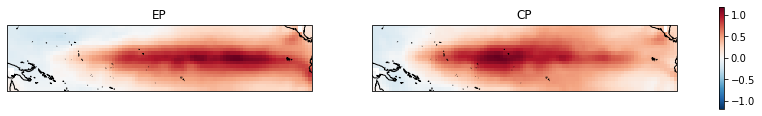

In [121]:
fig = plt.figure(figsize = (15,2.5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = EP_regress_had.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = CP_regress_had.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)

plt.savefig('HadISST_EP_CP_SST_pattern_NINO', bbox_inches='tight', dpi=300)

In [16]:
# Pattern Correlations
EP_pattern_cor = []
for m in EP_regressions.model:
    EP_pattern_cor.append(func.pattern_cor(EP_regressions.sel(model=m), EP_regress_had))
    
CP_pattern_cor = []
for m in CP_regressions.model:
    CP_pattern_cor.append(func.pattern_cor(CP_regressions.sel(model=m), CP_regress_had))

In [17]:
had_EP_sst_nino = EP_pattern_cor.copy()
had_CP_sst_nino = CP_pattern_cor.copy()

In [18]:
%store had_EP_sst_nino
%store had_CP_sst_nino

Stored 'had_EP_sst_nino' (list)
Stored 'had_CP_sst_nino' (list)


In [67]:
# Make pandas dataframe 
model_names = data.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], EP_pattern_cor[i], CP_pattern_cor[i]]
    pandas_data.append(cell)
    
df = pd.DataFrame(pandas_data, columns=['Model', 'EP', 'CP'])
df.head()

,Model,EP,CP
0,ACCESS-CM2,0.936995,0.858916
1,ACCESS-ESM1-5,0.870295,0.625261
2,BCC-CSM2-MR,0.843564,0.751706
3,CanESM5,0.875522,0.753312
4,EC-Earth3,0.962396,0.897202


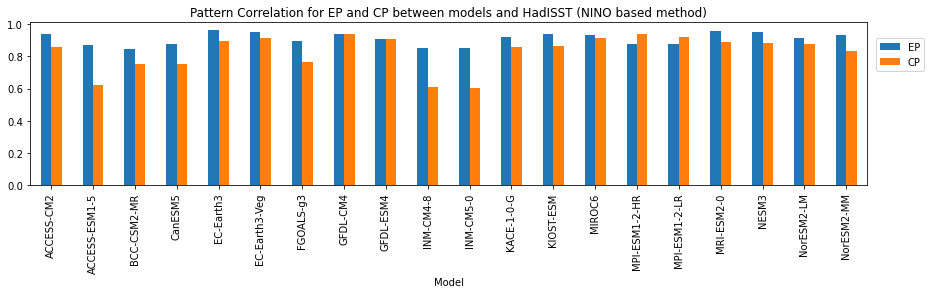

In [116]:
df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('Pattern Correlation for EP and CP between models and HadISST (NINO based method)')
plt.savefig('CMIP6_EP_CP_pattern_corr_NINO', bbox_inches='tight', dpi=300)

In [76]:
%store -r df_EOF

In [103]:
names = df['Model']
EP = df['EP']
E = df_EOF['E']
CP = df['CP']
C = df_EOF['C']

In [111]:
Es = pd.DataFrame([names, EP, E]).transpose()
Cs = pd.DataFrame([names, CP, C]).transpose()

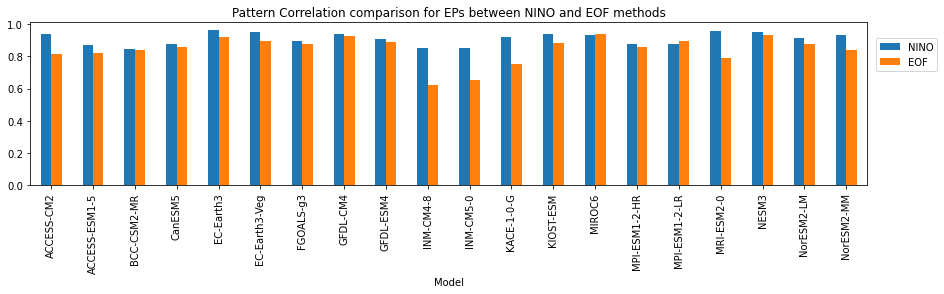

In [117]:
Es.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(labels=['NINO', 'EOF'], loc=(1.01,0.7))
plt.title('Pattern Correlation comparison for EPs between NINO and EOF methods')
plt.savefig('CMIP6_EP_pattern_corr_NINO_EOF', bbox_inches='tight', dpi=300)

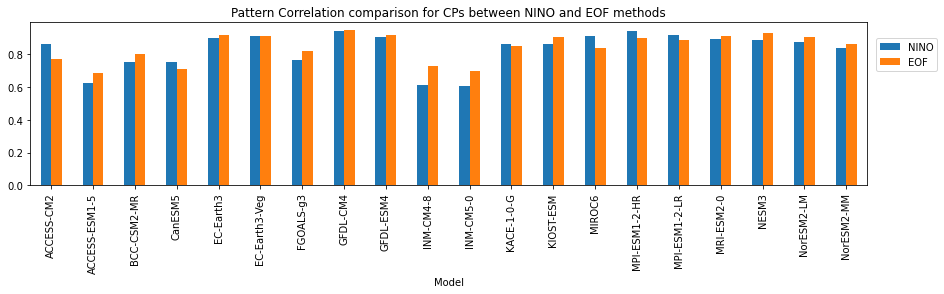

In [118]:
Cs.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(labels=['NINO', 'EOF'], loc=(1.01,0.7))
plt.title('Pattern Correlation comparison for CPs between NINO and EOF methods')
plt.savefig('CMIP6_CP_pattern_corr_NINO_EOF', bbox_inches='tight', dpi=300)

#### Location of Maximum Variability

In [17]:
EP_longitudes = []

for m in EP_regressions.model:
    a = EP_regressions.sel(model=m)
    location = np.where(a == np.max(a))
    lon_index = location[1][0]
    longitude = a.isel(lon=lon_index).lon.values
    EP_longitudes.append(longitude)

In [18]:
CP_longitudes = []

for m in CP_regressions.model:
    a = CP_regressions.sel(model=m)
    location = np.where(a == np.max(a))
    lon_index = location[1][0]
    longitude = a.isel(lon=lon_index).lon.values
    CP_longitudes.append(longitude)

In [20]:
had_location_EP = np.where(EP_regress_had == np.max(EP_regress_had))
had_lon_index_EP = had_location_EP[1][0]
had_longitude_EP = EP_regress_had.isel(lon=had_lon_index_EP).lon.values

In [22]:
had_location_CP = np.where(CP_regress_had == np.max(CP_regress_had))
had_lon_index_CP = had_location_CP[1][0]
had_longitude_CP = CP_regress_had.isel(lon=had_lon_index_CP).lon.values

In [24]:
%store EP_longitudes

Stored 'EP_longitudes' (list)


In [25]:
%store CP_longitudes

Stored 'CP_longitudes' (list)


In [26]:
%store had_longitude_EP

Stored 'had_longitude_EP' (ndarray)


In [27]:
%store had_longitude_CP

Stored 'had_longitude_CP' (ndarray)
